<a href="https://colab.research.google.com/github/codyshen0000/My_Test_Code/blob/main/Normalizing_flows_in_PyTorch_(part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前面我们讨论了通过一系列可逆非线性变换将简单的分布转换为较为复杂的分布，接下来要学习更多先进的normalizing flows based on torch.distributions

# Quick recap
Normalizing flow allow to transform a probability distribution, through a series of change of variable. For a single transform, if $\mathbf{z}\in\mathcal{R}^d$ be a random variable with distribution $q(\mathbf{z})$ and $f:\mathcal{R}^d\rightarrow\mathcal{R}^d$ an invertible smooth mapping, we obtain the following transformation

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}
\tag{1}
$$
Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
\tag{2}
$$
Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ in log-probability will be given by

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
\tag{3}
$$
For practical use fo these flow, we need some transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions.

# PyTorch distributions
We still rely on the novel [PyTorch distributions](https://pytorch.org/docs/stable/_modules/torch/distributions/) module, which is defined in torch.distributions. Here we define some basic imports and variables

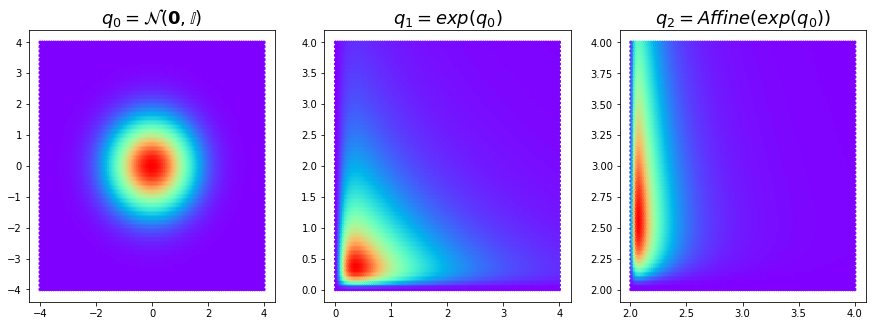

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Define an affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
ax3.hexbin(z[:,0], z[:,1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title('$q_2=Affine(exp(q_0))$', fontsize=18);

# Optimizing normalizing flows

*    planar flow 
$$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)
   \tag{2}
   $$
$$
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{3}
$$$$
\left|\text{det}\frac{\delta f}{\delta\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{4}
$$
$h(.)=tanh(.)$)
*   Radial flow
$$
   f(\mathbf{z})=\mathbf{z}+\beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)
   \tag{5}
   $$
$\beta$ 是标量，$\alpha$是正标量$r=\left\lVert\mathbf{z}-\mathbf{z}_0\right\rVert$ 并且 $h(\alpha,r)=1/(\alpha+r)$.所以雅克比行列式为：
$$
\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = \left(1 + \beta h(\alpha,r) + \beta h'(\alpha,r)r\right)(1+\beta h(\alpha,r))^{d-1}
\tag{6}
$$



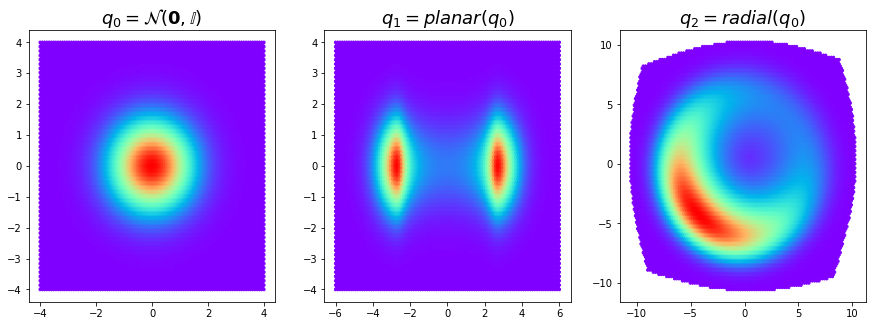

In [4]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)


class PlanarFlow(Flow):

    def __init__(self, dim, h=torch.tanh, hp=(lambda x: 1 - torch.tanh(x) ** 2)):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.h = h
        self.hp = hp
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.h(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = self.hp(f_z) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)


class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)


def change_density(q0_density, flow, z):
    # Apply our transform on coordinates
    f_z = flow(torch.Tensor(z)).detach()
    # Obtain our density
    q1_density = q0_density.squeeze() / np.exp(flow.log_abs_det_jacobian(torch.Tensor(z)).detach().squeeze())
    return q1_density, f_z

# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our transform
flow = PlanarFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.weight.data = torch.Tensor([[4, 0]])
flow.scale.data = torch.Tensor([[2, 0]])
flow.bias.data = torch.Tensor([0])
q1_density, f_z = change_density(q0_density, flow, z)

# Our transform
flow2 = RadialFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow2.z0.data = torch.Tensor([[0.5, 0.5]])
flow2.alpha.data = torch.Tensor([1])
flow2.beta.data = torch.Tensor([8])
q2_density, f_z2 = change_density(q0_density, flow2, z)

# Plot this
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=radial(q_0)$', fontsize=18);

# ReLU flow

tensor([1.2994e-08, 1.3393e-08, 1.3805e-08,  ..., 4.9500e-09, 4.8003e-09,
        4.6549e-09])
tensor([[-4.3530, -4.3530],
        [-4.3459, -4.3553],
        [-4.3387, -4.3575],
        ...,
        [ 8.8628,  8.8962],
        [ 8.8757,  8.8924],
        [ 8.8887,  8.8887]])


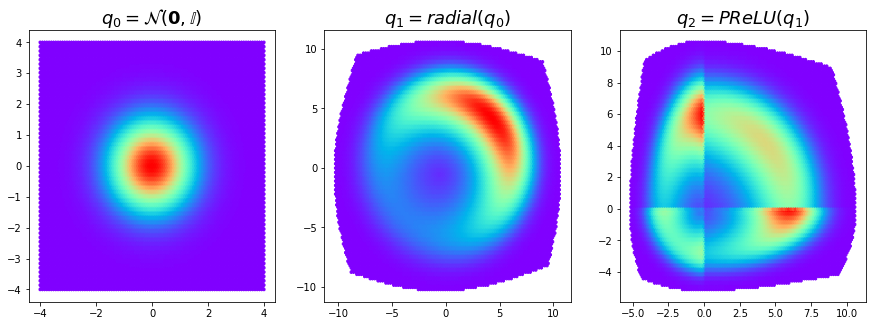

In [5]:
# Flow version of Leaky ReLU
class PReLUFlow(Flow):
    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.bijective = True

    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(0.01, 0.99)

    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)

    def _inverse(self, z):
        return torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)

    def log_abs_det_jacobian(self, z):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim = 1)


# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our radial transform
flow = RadialFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.z0.data = torch.Tensor([[-0.5, -0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z = change_density(q0_density, flow, z)
# Our ReLU flow
flow = PReLUFlow(2) 
# Manually set the transform parameters (dirty again ^^)
flow.alpha.data = torch.Tensor([0.5])
q2_density, f_z2 = change_density(q1_density, flow, f_z)
print(q2_density)
print(f_z2)
# Plot this
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=PReLU(q_1)$', fontsize=18);

#  Batch Normalization


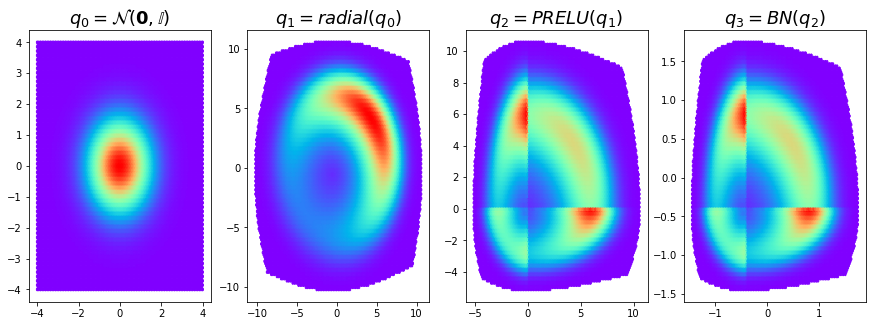

In [12]:

class BatchNormFlow(Flow):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our radial transform
flow = RadialFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.z0.data = torch.Tensor([[-0.5, -0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z = change_density(q0_density, flow, z)
# Our ReLU flow
flow = PReLUFlow(2) 
# Manually set the transform parameters (dirty again ^^)
flow.alpha.data = torch.Tensor([0.5])
q2_density, f_z2 = change_density(q1_density, flow, f_z)
# Our ReLU flow
flow = BatchNormFlow(2) 
# Manually set the transform parameters (dirty again ^^)
# flow.alpha.data = torch.Tensor([0.5])
q3_density, f_z3 = change_density(q2_density, flow, f_z2)

# Plot this
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=PRELU(q_1)$', fontsize=18);
ax4.hexbin(f_z3[:,0], f_z3[:,1], C=q3_density.numpy().squeeze(), cmap='rainbow')
ax4.set_title('$q_3=BN(q_2)$', fontsize=18);

# Affine transforms

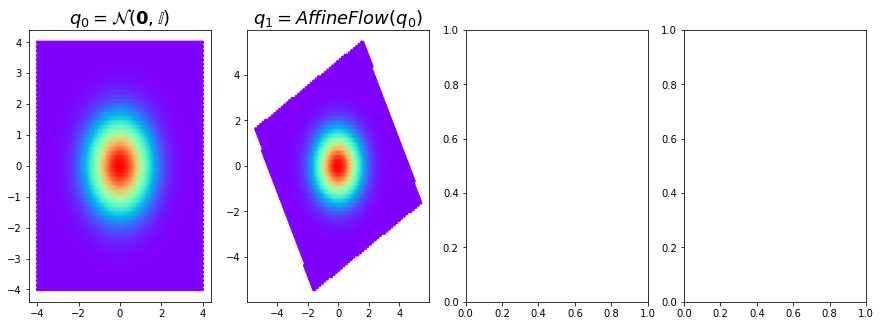

In [14]:
## Flow version of affine transform
class AffineFlow(Flow):
    def __init__(self, dim):
        super(AffineFlow, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(dim, dim))
        nn.init.orthogonal_(self.weights)

    def _call(self, z):
        return z @ self.weights
    
    def _inverse(self, z):
        return z @ torch.inverse(self.weights)

    def log_abs_det_jacobian(self, z):
        return torch.slogdet(self.weights)[-1].unsqueeze(0).repeat(z.size(0), 1)



# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))

# Our AffineFlow:
flow = AffineFlow(2)
q1_density, f_z = change_density(q0_density, flow, z)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=AffineFlow(q_0)$', fontsize=18);

# Optimizing multi-layer perceptron flow

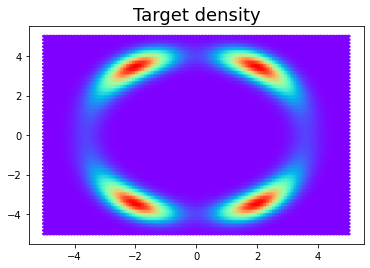

In [15]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

Loss (it. 0) : 18.406446
Loss (it. 1000) : 1.464549
Loss (it. 2000) : 1.329140
Loss (it. 3000) : 1.235728
Loss (it. 4000) : 1.180363
Loss (it. 5000) : 1.227390
Loss (it. 6000) : 1.150840
Loss (it. 7000) : 1.158509
Loss (it. 8000) : 1.207625
Loss (it. 9000) : 1.133140
Loss (it. 10000) : 1.415900


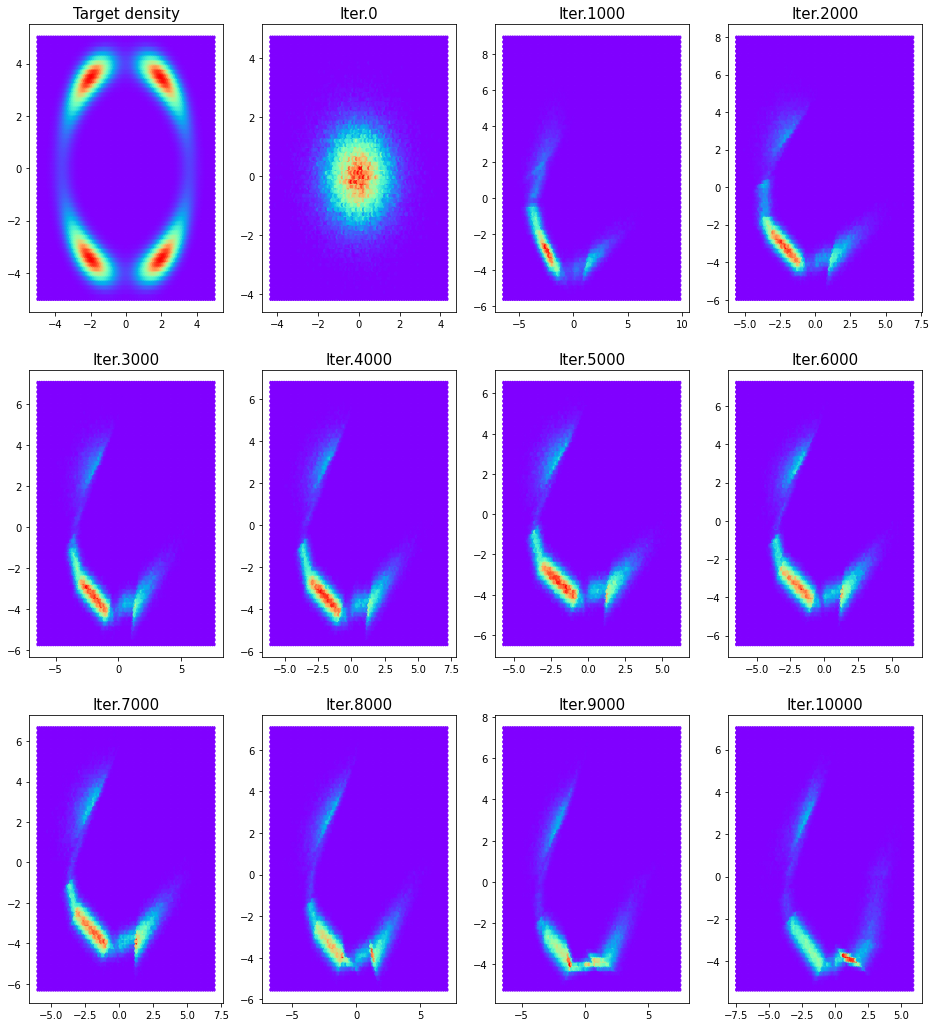

In [16]:

# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

# Our MLP blocks
block_mlp = [
    AffineFlow,
    BatchNormFlow,
    PReLUFlow
]
# Create normalizing flow
flow = NormalizingFlow(dim=2, blocks=block_mlp, flow_length=8, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1